<a href="https://colab.research.google.com/github/ncsu-landscape-dynamics/LAMP_assay_automation/blob/main/Working_pytorch_instance_imseg_resized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

class four_chs(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, target_transform=None):
        self.root = root
        self.transforms = transforms
        self.target_transform = target_transform
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imgs_resized"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks_resized"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "imgs_resized", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks_resized", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        # Convert from image object to array
        mask = np.array(mask)
        
        obj_ids = np.unique(mask)
        # first is background, other values are noise, removed them
        obj_ids = obj_ids[-4:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

Mounted at /content/drive


In [2]:
#os.chdir('drive/MyDrive/Colab Notebooks')

%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 29235, done.
remote: Counting objects: 100% (1777/1777), done.
remote: Compressing objects: 100% (457/457), done.
remote: Total 29235 (delta 1336), reused 1699 (delta 1287), pack-reused 27458
Receiving objects: 100% (29235/29235), 37.31 MiB | 30.74 MiB/s, done.
Resolving deltas: 100% (21951/21951), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
dataset0 = four_chs(root="/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers")

In [ ]:
dataset0[0]

(<PIL.Image.Image image mode=RGB size=747x1328 at 0x7FE03DD8AD90>,
 {'area': tensor([34928., 12769., 12769., 12769.]),
  'boxes': tensor([[394., 502., 512., 798.],
          [399., 687., 512., 800.],
          [399., 687., 512., 800.],
          [399., 687., 512., 800.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
          

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [5]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = four_chs(root = '/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers', transforms = get_transform(train=True))    
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=1, shuffle=True, num_workers=2,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)          

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [7]:
# use our dataset and defined transformations
dataset = four_chs(root = '/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers', transforms = get_transform(train=True))
dataset_test = four_chs(root = '/content/drive/MyDrive/APHIS Farm Bill (2020Milestones)/Protocols/For John/images/New set for John/collection/four_chambers', transforms = get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-4])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-4:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has five classes
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [9]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/20]  eta: 0:00:37  lr: 0.000268  loss: 0.8027 (0.8027)  loss_classifier: 0.4291 (0.4291)  loss_box_reg: 0.1490 (0.1490)  loss_mask: 0.1836 (0.1836)  loss_objectness: 0.0214 (0.0214)  loss_rpn_box_reg: 0.0196 (0.0196)  time: 1.8699  data: 1.1682  max mem: 1392
Epoch: [0]  [10/20]  eta: 0:00:06  lr: 0.002897  loss: 0.7684 (0.8032)  loss_classifier: 0.2704 (0.2903)  loss_box_reg: 0.1490 (0.1652)  loss_mask: 0.2035 (0.3132)  loss_objectness: 0.0214 (0.0209)  loss_rpn_box_reg: 0.0107 (0.0137)  time: 0.6607  data: 0.2994  max mem: 1666
Epoch: [0]  [19/20]  eta: 0:00:00  lr: 0.005000  loss: 0.7045 (0.8871)  loss_classifier: 0.1690 (0.2222)  loss_box_reg: 0.1305 (0.1472)  loss_mask: 0.2964 (0.4796)  loss_objectness: 0.0258 (0.0275)  loss_rpn_box_reg: 0.0099 (0.0105)  time: 0.5776  data: 0.2339  max mem: 1666
Epoch: [0] Total time: 0:00:11 (0.5818 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:01  model_time: 0.1974 (0.1974)  evaluator_time: 0.0020 (0.0020)  ti

In [10]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

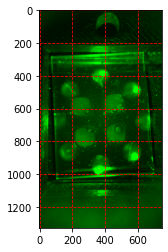

In [22]:
img1 = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

plt.imshow(img1)
ax = plt.gca()
ax.grid(True, color='r', linestyle='--')
plt.draw()
plt.show()

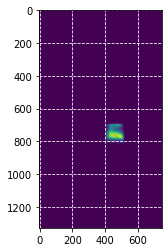

In [21]:
pred1 = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

plt.imshow(pred1)
ax = plt.gca()
ax.grid(True, color='w', linestyle='--')
plt.draw()
plt.show()